In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

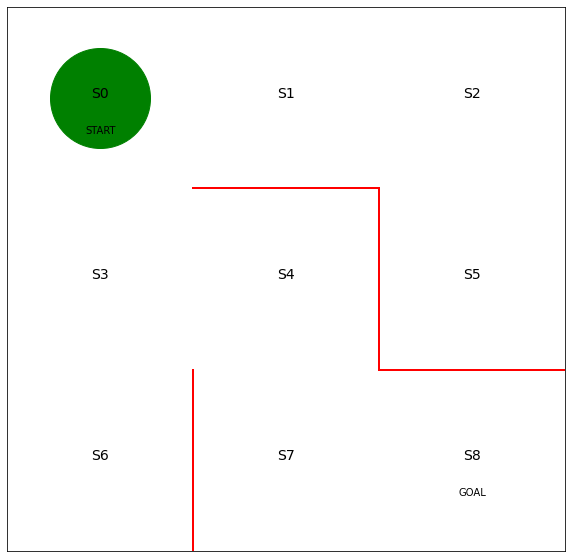

In [2]:
'''
초기 상태 미로 크기
'''
fig = plt.figure(figsize = (10, 10))
ax = plt.gca()

'''
붉은 벽 그리기
'''
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

'''
상태 문자열 표시: S0 ~ S8
'''
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

'''
범위 및 눈금 제거
'''
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

plt.tick_params(
    axis='both', 
    which='both', 
    bottom=False, 
    top=False, 
    labelbottom=False, 
    right=False, 
    left=False, 
    labelleft=False
)

'''
Start 위치에 녹색 원으로 현재 위치 표시
'''
line, = ax.plot([0.5], [2.5], marker = "o", color = 'g', markersize = 100)

# 가치 반복 (Q-learning Algorithm)

In [3]:
'''
정책 - policy - pi
policy의 초기값 설정

행은 상태 0 ~ 7, 열은 행동 방향(상, 우, 하, 좌)를 나타낸다.
'''
theta_0 = np.array(
    [
        [np.nan, 1, 1, np.nan],  # s0
        [np.nan, 1, np.nan, 1],  # s1
        [np.nan, np.nan, 1, 1],  # s2
        [1, 1, 1, np.nan],  # s3
        [np.nan, np.nan, 1, 1],  # s4
        [1, np.nan, np.nan, np.nan],  # s5
        [1, np.nan, np.nan, np.nan],  # s6
        [1, 1, np.nan, np.nan],  # s7
        # ※s8은 목표지점이므로 정책이 없다
    ]
)

In [5]:
print(theta_0)
print(theta_0.shape)

[[nan  1.  1. nan]
 [nan  1. nan  1.]
 [nan nan  1.  1.]
 [ 1.  1.  1. nan]
 [nan nan  1.  1.]
 [ 1. nan nan nan]
 [ 1. nan nan nan]
 [ 1.  1. nan nan]]
(8, 4)


In [7]:
'''
정책 파라미터 theta_0를 무작위 행동 정책 pi로 변환하는 함수 정의
'''
def softmax_convert_into_pi_from_theta(theta):
    
    # inverse temperature
    beta = 1.0
    
    # theta 행렬의 크기
    [m, n] = theta.shape
    
    pi = np.zeros((m, n))
    
    # theta를 exp(theta)로 치환
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        
        # softmax function을 이용한 비율 계산
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    
    # nan을 0으로 치환
    pi = np.nan_to_num(pi)
    
    return pi

In [9]:
'''
정의된 함수를 실행하여 theta zero로부터 초기 policy pi(s,a)를 구한다.
'''
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

In [11]:
print(pi_0)
print(pi_0.shape)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]
(8, 4)


## Q-learining Algorithm 구현

Q-learning과 Sarsa의 차이점은 행동가치 함수 Q를 수정하는 식만 다른 것이다.

* Sarsa: Q(s, a, t) = Q(s, a, t) + eta * [R(t+1) + gamma * Q(s+1, a+1, t) - Q(s, a, t)]

* Q-learning: Q(s, a, t) = Q(s, a, t) + eta * [R(t+1) + gamma_max * Q(s+1, a+1, t) - Q(s, a, t)]

Sarsa 알고리즘에서느 다음에 취할 행동 a(t+1)을 구해서 행동가치 함수를 수정하는 데 사용했지만 Q-learning에서는 상태 s(t+1)에 대한 각 행동가치 함수값 중 가장 값이 큰 것을 사용하여 행동가치 함수를 수정한다. 

Sarsa는 다음 단계 행동 a(t+1)을 사용해 행동가치 함수 Q를 수정하므로 Q를 수정할 때 a(t+1)을 구하기 위해 정책에 의존한다는 특징이 있다. 이러한 특징을 '온-폴리시(On-policy)'라고 한다.

Q-learning은 행동가치 함수 Q를 수정할 때 정책에 의존하지 않는다. 이러한 특징을 '오프-폴리시(Off-policy)'라고 한다. epsilon-greedy 알고리즘 특성상 나타나는 무작위 행동이 수정식에 포함되지 않는 만큼 행동가치 함수가 Sarsa보다 빨리 수렴하는 것이 특징이다.

In [12]:
'''
가치반복 알고리즘에서 사용할 행동가치 함수를 표형식으로 구현한다.
행: 상태 s
열: 행동 a
행동가치 함수: Q(s, a)

실제 행동가치는 알 수 없으므로 초기 상태로 난수값을 부여한다.

행동가치 함수에 theta 값을 곱해주는 이유는 난수 중에 벽에 해당하는 부분을 np.nan으로 변경해주기 위해서이다.

Q의 초깃값이 너무 크면 애니메이션으로 나타내기 어려우므로 0.1을 곱해 Q 값을 줄인다.
'''

# * theta_0으로 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan을 부여
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1

In [13]:
'''
epsilon-greedy 알고리즘 구현

행동을 결정하는 함수 get_action과 행동 a를 인자로 받아 다음 상태를 구하는 함수 get_state_next로 나누어 구현한다.
'''

def get_action(state, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    
    # 행동 결정
    if np.random.rand() < epsilon:
        
        # 확률 epsilon으로 무작위 행동 선택
        next_direction = np.random.choice(direction, p = pi_0[state, :])
        
    else:
        
        # Q 값이 최대가 되는 행동 선택
        next_direction = direction[np.nanargmax(Q[state, :])]
        
    # 행동을 인덱스로 변환
    if next_direction == "up":
        action = 0
    
    elif next_direction =="right":
        action = 1
        
    elif next_direction =="down":
        action = 2
        
    elif next_direction =="left":
        action = 3
        
    return action

def get_state_next(state, action, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    
    # 행동 a의 방향
    next_direction = direction[action]
    
    # 입력받은 행동 a로 다음 상태 결정
    if next_direction == "up":
        
        # 위쪽으로 이동하면 상태값이 3만큼 감소
        state_next = state - 3
        
    elif next_direction == "right":
        
        # 오른쪽으로 이동하면 상태값이 1만큼 증가
        state_next = state + 1
        
    elif next_direction == "down":
        
        # 아래쪽으로 이동하면 상태값이 3만큼 증가
        state_next = state + 3
        
    elif next_direction == "left":
        
        # 왼쪽으로 이동하면 상태값이 1만큼 감소
        state_next = state - 1
        
    return state_next

## 행동가치 함수 Q(s, a)를 Q-learning 알고리즘으로 수정

행동가치 함수 Q(s, a)가 제대로 된 값이 될 수 있도록 학습하는 부분을 구현한다.

Sarsa 알고리즘과의 차이점은 오차부분이 다르므로 오차부분만 수정한다.

* Q(s, a, t) = Q(s, a, t) + eta * [R(t+1) + gamma_max * Q(s+1, a+1, t) - Q(s, a, t)]

In [16]:
'''
Q-learning 알고리즘 구현
'''
def Q_learning(state, action, reward, state_next, a_next, Q, eta, gamma):
    
    # 에이전트가 목표 지점에 도달한 경우
    if state_next == 8:
        Q[state, action] = Q[state, action] + eta * (reward + Q[state, action])
    
    # 에이전트가 목표 지점에 도달하지 못한 경우
    else:
        Q[state, action] = Q[state, action] + eta * (reward + gamma * np.nanmax(Q[state_next, :]) - Q[state, action])
        
    return Q

In [17]:
'''
Q-learning 알고리즘을 사용하여 에이전트가 목표에 도달할 수 있도록 함수를 구현한다.

시작 지점부터 목표 지점에 한번 다다르는 과정까지 학습과정이 아닌, 한번의 action 단위로 학습할 수 있도록 수정한다.

마지막 부분에 미로를 헤매지 않고 곧장 빠져나갈 수 있도록 반복해서 가치함수를 수정하는 부분을 구현한다. 

상태가치 함수 V(s)는 각 상태 s에서 행동가치 함수 Q(s, a)의 최댓값을 계산한다.
'''
def goal_maze_ret_state_action_Q(Q, epsilon, eta, gamma, pi):
    
    # 시작 지점
    state = 0
    
    # 첫 번째 행동
    action = a_next = get_action(state, Q, epsilon, pi)
    
    # 에이전트의 행동 및 상태의 히스토리를 기록하는 리스트
    state_action_history = [[0, np.nan]]
    
    # 목표 지점에 다다를 때까지 반복
    while (1):
        
        # 행동 결정
        action = a_next
        
        # 현재 상태(마지막이므로 인덱스가 -1)를 히스토리에 추가
        state_action_history[-1][1]
        
        # 다음 단계의 상태를 구함
        state_next = get_state_next(state, action, Q, epsilon, pi)
        
        # 다음 상태를 히스토리에 추가, 행동은 아직 알 수 없으므로 nan 값 부여
        state_action_history.append([state_next, np.nan])
        
        # 보상을 부여하고 다음 행동을 계산
        if state_next == 8:
            
            # 목표 지점에 도달했다면 보상을 부여
            reward = 1
            
            # 목표 지점에 도달했기 때문에 다음 정책이 없음
            a_next = np.nan
            
        else:
            
            # 목표 지점에 도달하지 못 했다면 보상을 부여하지 않음
            reward = 0
            
            # 목표 지점에 도달하지 못 했기 때문에 다음 정책을 부여
            a_next = get_action(state_next, Q, epsilon, pi)
            
        # 가치함수 수정
        Q = Q_learning(state, action, reward, state_next, a_next, Q, eta, gamma)
        
        # 종료 여부 결정
        if state_next == 8:
            
            # 목표 지점에 도달했다면 while문 종료
            break
            
        else:
            
            # 목표 지점에 도달하지 못 했다면 while문 지속
            state = state_next
            
    return [state_action_history, Q]

In [18]:
'''
Q_learning 알고리즘을 이용하여 미로를 빠져나오는 프로그램 구현

eta: 학습률
gamma: 시간할인율
epsilon: epsilon-greedy 알고리즘에서 epsilon 초깃값
v: 상태가치함수
'''
eta = 0.1
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis = 1)
is_continue = True
epoch = 1

# epoch 별로 상태가치를 저장
V = []

# 상태별로 행동가치의 최댓값을 계산
V.append(np.nanmax(Q, axis = 1))

# is_continue의 값이 False가 될 때까지 반복
while is_continue:
    
    # epsilon 값 감소
    epsilon = epsilon / 2
    
    # Sarsa 알고리즘으로 미로를 빠져나온 후, 결과로 나온 행동 히스토리와 행동 가치함수 Q 값을 변수에 저장
    [state_action_history, Q] = goal_maze_ret_state_action_Q(Q, epsilon, eta, gamma, pi_0)
    
    # 각 상태마다 행동가치의 최댓값을 계산, 상태가치 함수의 변화를 출력
    updated_v = np.nanmax(Q, axis = 1)
    delta_v = updated_v - v
    total_change_v = np.sum(np.abs(delta_v))
    
    print(total_change_v)
    
    # 상태가치 함수 업데이트
    v = updated_v
    
    # 단계 수 출력
    print("Epoch: {} | 목표 지점(S8)에 도달하기까지 걸린 단계 수: {} 단계".format(epoch, len(state_action_history) - 1))
    
    # 100 epoch 반복
    epoch  = epoch + 1
    if epoch > 100:
        break

0.22268529213466176
Epoch: 1 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 242 단계
0.13219645435650187
Epoch: 2 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 6 단계
0.28888689551761704
Epoch: 3 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 466 단계
0.21650614950537198
Epoch: 4 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 276 단계
0.2103201366927131
Epoch: 5 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 10 단계
0.23950778699846936
Epoch: 6 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.27217783444299054
Epoch: 7 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.30794672519104055
Epoch: 8 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.34711649876875156
Epoch: 9 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.3900180776706174
Epoch: 10 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.4370149554571737
Epoch: 11 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.48850706119652454
Epoch: 12 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.544934852950832
Epoch: 13 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.606783692733167
Epoch: 14 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.6745885558610107
Epoch: 15 | 목표 지점(S8)에 도달하기까지 걸린 단계 수: 4 단계
0.7489391288779758
Epoch: 16 | 목표 지점(S8)에 도달하기까지 걸

In [19]:
'''
학습이 끝난 행동가치 함수 Q 확인
'''
print(Q)
print(Q.shape)

[[           nan 2.28057812e-02 1.36951082e+03            nan]
 [           nan 2.28923495e-02            nan 2.26905473e-02]
 [           nan            nan 2.28687925e-02 2.27857864e-02]
 [2.29930113e-02 3.04416573e+03 2.28667013e-02            nan]
 [           nan            nan 6.76571242e+03 4.93515327e-02]
 [2.28457316e-02            nan            nan            nan]
 [2.28011680e-02            nan            nan            nan]
 [1.61383121e-02 1.50359165e+04            nan            nan]]
(8, 4)


In [20]:
'''
상태 이력을 따라 화면 상의 미로에서 에이전트를 이동시키는 애니메이션을 구현한다.
'''

from matplotlib import animation
from IPython.display import HTML

def init():
    
    # 배경 이미지 초기화
    line.set_data([], [])
    
    return (line,)

def animate(i):
    
    # 프레임 단위 이미지 생성
    
    # 현재 위치
    state = state_action_history[i][0]
    
    # 상태 s의 x좌표(3으로 나눈 나머지 + 0.5)
    x = (state % 3) + 0.5
    
    # 상태 s의 y좌표(2.5에서 3으로 나눈 몫을 뺌)
    y = 2.5 - int(state / 3)
    
    line.set_data(x, y)
    
    return (line,)

In [21]:
'''
init() 함수와 animate() 함수를 사용하여 애니메이션 생성
'''
anim = animation.FuncAnimation(
    fig,
    animate, 
    init_func = init,
    frames = len(state_action_history),
    interval = 200,
    repeat = False
)

HTML(anim.to_jshtml())